# Matplotlib Intro

In this reading, we'll learn how to create plots from Pandas data.  Pandas uses a module called matplotlib to create plots.  The matplotlib library is designed to resemble MATPLOT (a programming language for matrices and environment that support visualization).

While we could import matplotlib and make function calls directly to plot data, many Pandas methods for Series and DataFrame objects make this easier.  The documentation gives a nice overview of this integration [here](https://pandas.pydata.org/pandas-docs/stable/visualization.html) with more examples than provided here.

Let's begin by trying to make a pie chart from a Pandas Series.

In [1]:
import pandas as pd
from pandas import Series, DataFrame

In [2]:
# first we'll create a Series with three numbers
s = Series([50, 30, 20])
s

0    50
1    30
2    20
dtype: int64

In [3]:
# there are a bunch of methods of the form Series.plot.METHOD for plotting.
# we we want a pie plot:
s.plot.pie()

**Oops!**  That's not what we wanted.  We created a plot, but it didn't get rendered in the notebook.  It turns out that matplotlib is integrated with Jupyter Notebooks, and sometimes we need a special command to tell Jupyter we want to render plots inline.  Special Jupyter commands begin with a percent sign ("%").  We recommend putting the following at the beginning of all your notebooks (it's a Jupyter command, not Python code, so it won't work in a regular .py file if you were to try that):

In [4]:
%matplotlib inline

Ok, let's try plotting again.

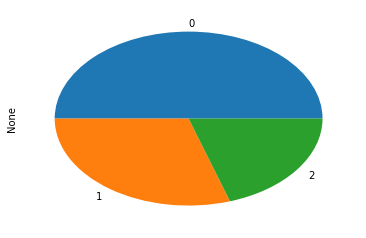

In [5]:
s.plot.pie()

Now we're getting somewhere!  Of course, there are still many issues with this plot:
1. it's oval (not round)
2. each slice is numbered (not labeled)
3. it says "None" to the left

## Pie Plot

Let's address some of the issues we just saw.  First, we can pass a `figsize` tuple argument to specify the (width, height) in inches.  Let's make the pie chart a 6-by-6 inch square.

In [6]:
s = Series([50, 30, 20])
s

0    50
1    30
2    20
dtype: int64

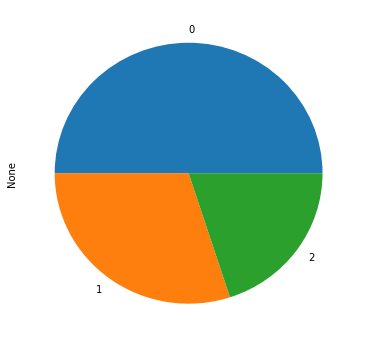

In [7]:
s.plot.pie(figsize=(6,6))

Great!  Now it's the right shape.  What about the slice labels?  These are based on the Series index.  Notice that the numbers 50, 30, and 20 have indices 0, 1, and 2 respectively:

In [8]:
s

0    50
1    30
2    20
dtype: int64

Let's give the Series custom labels and try again.

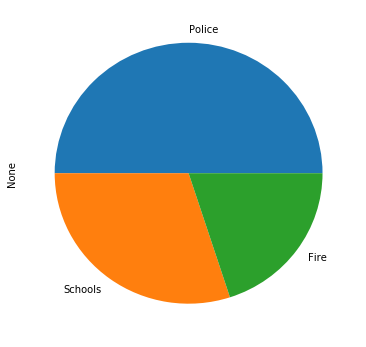

In [9]:
s = Series([50,30,20], index=['Police', 'Schools', 'Fire'])
s.plot.pie(figsize=(6,6))

The final thing to fix is the "None" label to the left.  This label comes from the Series name.  We haven't seen how to specify a Series name before, but it's easy:

In [10]:
s = Series([50,30,20], index=['Police', 'Schools', 'Fire'], name='City Budget')
s

Police     50
Schools    30
Fire       20
Name: City Budget, dtype: int64

Now that the Series was given a name with `name='City Budget'`, we will see it when we plot:

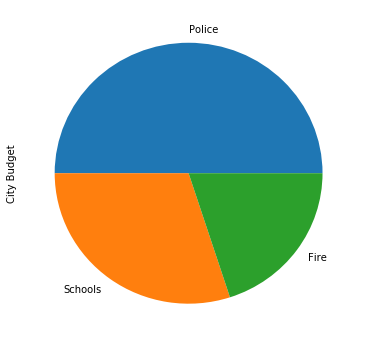

In [11]:
s.plot.pie(figsize=(6,6))

We can also override using the Series name as the label by passing a `label=NAME` argument.

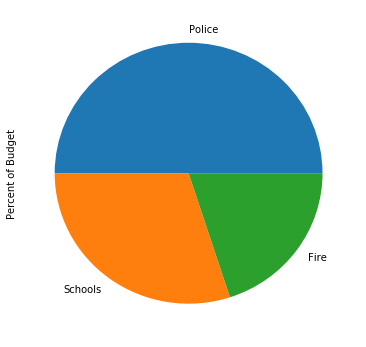

In [12]:
s.plot.pie(figsize=(6,6), label='Percent of Budget')

This means we can also choose not to have a label:

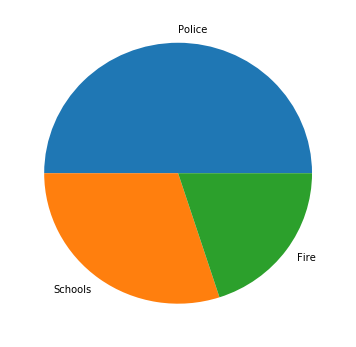

In [13]:
s.plot.pie(figsize=(6,6), label='')

Note that a label is different that a title.  Let's try having a pie chart with both.

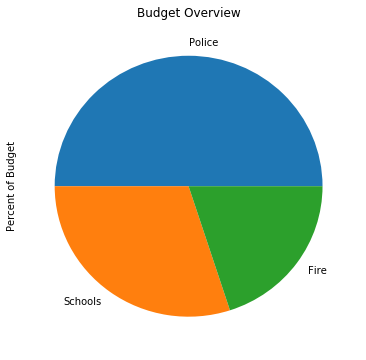

In [14]:
s.plot.pie(figsize=(6,6), label='Percent of Budget', title='Budget Overview')

One thing to be careful about is when the numbers in a Series sum to less than 1.  Matplotlib does not draw a complete pie in this case.

In [15]:
# let's say the numbers are in millions of dollars for a small town
s = Series([0.2,0.12,0.08], index=['Police', 'Schools', 'Fire'], name='City Budget')
s

Police     0.20
Schools    0.12
Fire       0.08
Name: City Budget, dtype: float64

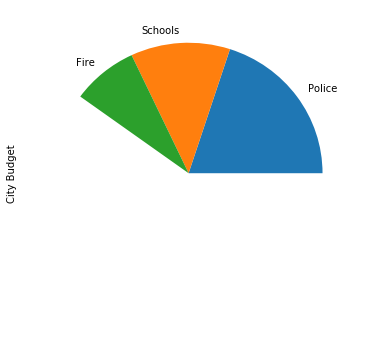

In [16]:
s.plot.pie(figsize=(6,6))

This is easy enough to fix by doing some element-wise multiplication to convert everything to a percent of a total.

In [17]:
percents = 100 * s / sum(s)
percents

Police     50.0
Schools    30.0
Fire       20.0
Name: City Budget, dtype: float64

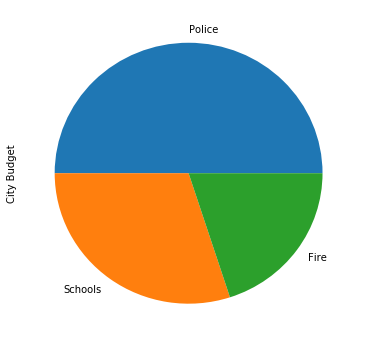

In [18]:
percents.plot.pie(figsize=(6,6))

As a finishing touch, we may want to annotate each slice with a percentage.  We can do this with the `autopct=FORMAT` argument.  `FORMAT` will be a Python format string, telling matplotlib how to display the number.  We haven't learned about format strings this semester, but `%d` will tell matplotlib to format as in integer, and `%f` will tell it to format as a float.  Let's display integers:

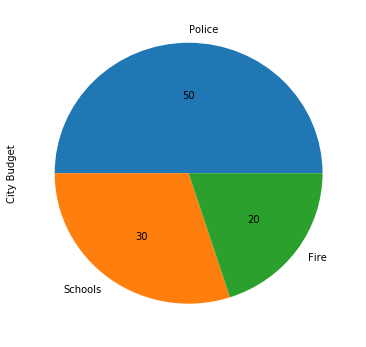

In [19]:
percents.plot.pie(figsize=(6,6), autopct='%d')

## Real Example: Madison Route Distribution

In this example, we want to show how many people ride the 5 most popular bus routes in Madison, relative to overall ridership.  We'll pull the data from our bus.db database we've used in previous examples.

In [20]:
import sqlite3

In [21]:
c = sqlite3.connect('bus.db')

In [22]:
# let's preview the data
pd.read_sql("SELECT * from boarding LIMIT 10", c)

,index,StopID,Route,Lat,Lon,DailyBoardings
0,0,1163,27,43.073655,-89.385427,1.03
1,1,1163,47,43.073655,-89.385427,0.11
2,2,1163,75,43.073655,-89.385427,0.34
3,3,1164,6,43.106465,-89.340021,10.59
4,4,1167,3,43.077867,-89.369993,3.11
5,5,1167,4,43.077867,-89.369993,2.23
6,6,1167,10,43.077867,-89.369993,0.11
7,7,1167,38,43.077867,-89.369993,1.36
8,8,1169,3,43.089707,-89.329817,18.90
9,9,1169,37,43.089707,-89.329817,1.35


In [23]:
# we want to see the total ridership per bus route
df = pd.read_sql("SELECT Route, SUM(DailyBoardings) as ridership " +
                 "FROM boarding " +
                 "GROUP BY Route " +
                 "ORDER BY ridership DESC", c)

# let's peek at the first few rows in the results from our query
df.head()

,Route,ridership
0,80,10211.79
1,2,4808.03
2,6,4537.02
3,10,4425.23
4,3,2708.55


Now's a good time to stop and think about what form the data is in, and what form we want to get it to.

**What we have:** a DataFrame of routes and ridership, indexed from 0.

**What we want:** a Series of the top 5 buses, with route numbers as the index, and ridership as the values.

Why do we want such a Series?  Because when we call `Series.plot.pie(...)` we want a pie with five slices.  Each pie should be labeled as a bus route (and slice labels are pulled from the index of a Series), and the size of the series should correspond to ridership (and slice sizes are based on the values in a Series).

The first step to getting the data in the form we want is to re-index `df` so that the route numbers are in the index (instead of 0, 1, 2, etc).  We can do this with the `DataFrame.set_index` function.

In [24]:
# set_index doesn't change df, but it returns a new
# DataFrame with the desired column as the new index
ridership_df = df.set_index("Route")
ridership_df.head()

,ridership
Route,
80,10211.79
2,4808.03
6,4537.02
10,4425.23
3,2708.55


In [25]:
# we can pull the (only) ridership column from that DataFrame out
# and keep it as a Series.
ridership = ridership_df['ridership']
ridership.head()

Route
80    10211.79
2      4808.03
6      4537.02
10     4425.23
3      2708.55
Name: ridership, dtype: float64

Great!  Now we have the data in a plottable form.  Let's make the pie chart.

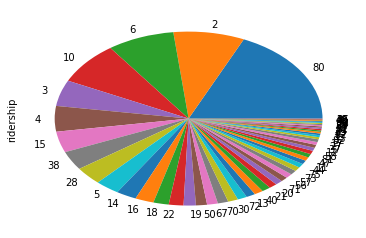

In [26]:
ridership.plot.pie()

This is very close to the form we want!  But we only wanted the top 5 routes.

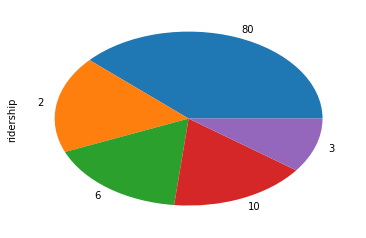

In [27]:
ridership.head(5).plot.pie()

Not bad, but we would ideally have an "other" category that captures all the routes besides the 80, 2, 6, 10, and 3.  How many routes are in this other category?

In [28]:
other_ridership = sum(ridership) - sum(ridership.head(5))
other_ridership

29296.560000000012

Now, we want to glue together the top five values from the `ridership.head(5)` series with a Series of one value (the ridership for other).  We can do this with `pd.concat`.

In [29]:
series1 = ridership.head()
series1

Route
80    10211.79
2      4808.03
6      4537.02
10     4425.23
3      2708.55
Name: ridership, dtype: float64

In [30]:
series2 = Series([other_ridership], index=['other'])
series2

other    29296.56
dtype: float64

In [31]:
plot_data = pd.concat([series1, series2])
plot_data

80       10211.79
2         4808.03
6         4537.02
10        4425.23
3         2708.55
other    29296.56
dtype: float64

That's exactly what we want!  The ridership of the top 5 routes, and the remaining ridership spread across other routes.  Let's plot it.

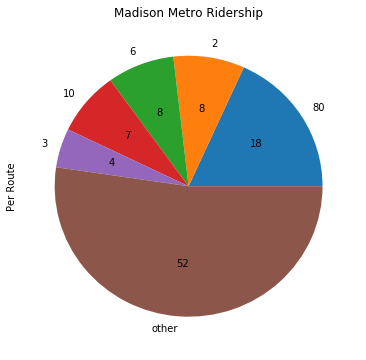

In [32]:
plot_data.plot.pie(figsize=(6,6), autopct="%d", label="Per Route", title="Madison Metro Ridership")

This is exactly what we want.  We can see the top route (the 80) is responsible for 18% of the ridership.  The top 5 routes together are responsible for almost half of all ridership (48%, to be exact).  To wrap up, let's make sure we close our connection to bus.db.

In [33]:
c.close()

## Scatter Plot